In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 시각화 전역 설정
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 15

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
# 경로 설정
data_path = '../../data'
saved_path = './saved'
output_path = './submission'

In [4]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
# history_df['profile_id'] = history_df['profile_id'].astype(str)
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
# watch_e_df['profile_id'] = watch_e_df['profile_id'].astype(str)
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
search_df  = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')

meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'), encoding='utf-8')

# preprocess

### 1) 메타 데이터 sub_title 리스트 담기

In [5]:
meta_df_sub_title_list_dict= {}

for idx, row in meta_df.iterrows():
    if meta_df_sub_title_list_dict.get(row['album_id'], None) == None:
        meta_df_sub_title_list_dict[row['album_id']] = [row['sub_title']]
    else:
        meta_df_sub_title_list_dict[row['album_id']] = meta_df_sub_title_list_dict[row['album_id']]+[row['sub_title']]
        
print('전체 컨텐츠 개수:',len(set(meta_df.album_id)),'딕셔너리 담긴 아이템 개수:',len(meta_df_sub_title_list_dict))        

meta_df_prepro_sub_title = meta_df.copy()
meta_df_prepro_sub_title['sub_title'] = meta_df_prepro_sub_title['album_id'].apply(lambda x: meta_df_sub_title_list_dict.get(x, None))

전체 컨텐츠 개수: 39875 딕셔너리 담긴 아이템 개수: 39875


- 39875 동일 한 것 확인

### 2) 메타 플러스 데이터 태그(keyword_name)리스트 담기

- keyword_type, keyword_name 모두 리스트에 담기

In [6]:
meta_plus_type_name = meta_plus_df.copy()

In [7]:
type_to_name = {}

for idx, row in meta_plus_df.iterrows():
    type_to_name[row['keyword_type']] = row['keyword_name']
    
meta_plus_type_name['keyword_name'] = meta_plus_type_name['keyword_type'].apply(lambda x: type_to_name[x])    

name_to_type = {}
for idx, row in meta_plus_df.iterrows():
    name_to_type[row['keyword_name']] = row['keyword_type']
    
meta_plus_type_name['keyword_type'] = meta_plus_type_name['keyword_name'].apply(lambda x: name_to_type[x])

In [8]:
len(set(meta_plus_type_name.keyword_name)), len(set(meta_plus_type_name.keyword_type))

(1062, 1062)

In [9]:
print('앨범 당 키워드 중복 여부 확인:',len(meta_plus_df),len(meta_plus_df.drop_duplicates(subset=['album_id','keyword_type'])))

앨범 당 키워드 중복 여부 확인: 767948 767948


- 중복 없음

In [10]:
# meta_plus_df_prepro_keyword = meta_plus_df[meta_plus_df['keyword_value']>=3]
meta_plus_df_prepro_keyword = meta_plus_type_name.copy()

- 메타 데이터 sub_title 리스트에 담기
- 메타 플러스 태그는 keyword_value가 3점 이상인 것만 리스트에 담기
- 3점 이상인 것만 넣으니 문제 발생 태그 없는 컨텐츠 1004건 발생
- 1.좀더 다른 컨텐츠랑 어울리게 포장할 것이냐(이 책 뭉뜽그려 다른 컨텐츠와 연관 있어!) 
- 2.이 책 자체를 제대로 표현하냐(이건 다른 컨텐츠랑 연관은 없어!)
- 1번 선택하자 2번 선택하면 1004 건 컨텐츠는 전부 None 으로 같은 컨텐츠 취급 받는거기 때문에??...
- 좀더 논의가 필요해보임! 하지만, 일단 1번 선택

### 3) meta plut data tpye name 동일하게 만들기

In [11]:
meta_df_keyword_name_list_dict= {}
meta_df_keyword_type_list_dict= {}

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_name_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_name_list_dict[row['album_id']] = [row['keyword_name']]
    else:
        meta_df_keyword_name_list_dict[row['album_id']] = meta_df_keyword_name_list_dict[row['album_id']]+[row['keyword_name']]

for idx, row in meta_plus_df_prepro_keyword.iterrows():
    if meta_df_keyword_type_list_dict.get(row['album_id'], None) == None:
        meta_df_keyword_type_list_dict[row['album_id']] = [row['keyword_type']]
    else:
        meta_df_keyword_type_list_dict[row['album_id']] = meta_df_keyword_type_list_dict[row['album_id']]+[row['keyword_type']]        

meta_plus_df_prepro_keyword['keyword_name'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_name_list_dict.get(x, None))
meta_plus_df_prepro_keyword['keyword_type'] = meta_plus_df_prepro_keyword['album_id'].apply(lambda x: meta_df_keyword_type_list_dict.get(x, None))

meta_plus_df_keyword = meta_plus_df_prepro_keyword.drop_duplicates(subset=['album_id'],ignore_index=True).drop(columns=['keyword_value'])

In [12]:
meta_df_sub_title = meta_df_prepro_sub_title.drop_duplicates(subset=['album_id'],ignore_index=True)
print('서로 중복 데이터 수:',len(set(meta_df_sub_title.album_id) - set(meta_plus_df_keyword.album_id)))

서로 중복 데이터 수: 0


### 4) meta data merge

In [13]:
all_meta_df = pd.merge(meta_df_sub_title, meta_plus_df_keyword, how='left',on='album_id')

### 5) profile preprocess

In [14]:
pr_interest_keyword_dict = {'P01':'과학기술',
                           'P02':'정서/사회성',
                           'P03':'자연탐구',
                           'P04':'바른생활/안전',
                           'P05':'활동/운동',
                           'P06':'음악예술',
                           'P07':'언어논리',
                           'P08':'수리논리'}
ch_interest_keyword_dict = {'K01':'노래/율동',
                           'K02':'동물/식물',
                           'K03':'동화',
                           'K04':'만들기',
                           'K05':'숫자/계산',
                           'K06':'외국어',
                           'K07':'친구/사람',
                           'K08':'탈것/기계',
                           'K09':'활동/운동'}

pr_list = ['pr_interest_keyword_cd_1','pr_interest_keyword_cd_2','pr_interest_keyword_cd_3']
ch_list = ['ch_interest_keyword_cd_1','ch_interest_keyword_cd_2','ch_interest_keyword_cd_3']
for pr in pr_list:
    profile_df[pr] = profile_df[pr].apply(lambda x: pr_interest_keyword_dict.get(x, np.NaN))
for ch in ch_list:
    profile_df[ch] = profile_df[ch].apply(lambda x: ch_interest_keyword_dict.get(x, np.NaN))
    

### 5) history_df & watch_e_df 와 merge

In [96]:
history_meta_df = pd.merge(history_df,all_meta_df, how='left', on='album_id')
history_meta_profile_df = pd.merge(history_meta_df,profile_df, how='left', on='profile_id')
history_meta_profile_duplicate_df = history_meta_profile_df.drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).reset_index(drop = True)
print('같은 시간 중복 시청 전처리 전 후:',len(history_meta_profile_df),len(history_meta_profile_duplicate_df))

같은 시간 중복 시청 전처리 전 후: 1005651 899252


In [16]:
watch_e_meta_df = pd.merge(watch_e_df,all_meta_df, how='left', on='album_id')
watch_e_meta_profile_df = pd.merge(watch_e_meta_df,profile_df, how='left', on='profile_id')
watch_e_meta_profile_duplicate_df = watch_e_meta_profile_df.drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).reset_index(drop = True)
print('같은 시간 중복 시청 전처리 전 후:',len(watch_e_meta_profile_df),len(watch_e_meta_profile_duplicate_df))

같은 시간 중복 시청 전처리 전 후: 892794 800632


In [17]:
# 어떤식으로 중복되는 지 확인해보자
watch_e_meta_profile_df[watch_e_meta_profile_df.duplicated(subset=['profile_id', 'album_id', 'log_time'])][['profile_id', 'album_id', 'log_time']].head()

,profile_id,album_id,log_time
507,5,298,20220421082953
509,5,92,20220421085005
511,5,174,20220421090233
513,5,201,20220421090327
515,5,187,20220421090443


In [18]:
# 이처럼 중복된 것들이 있음(다른 컬럼 값도 똑같음)
# 그런데 중복되면 2개씩만 있음

display(watch_e_meta_profile_df[(watch_e_meta_profile_df['profile_id']==33016)&\
                       (watch_e_meta_profile_df['album_id']==5873)&\
                       (watch_e_meta_profile_df['log_time']==20220424195327)][['profile_id', 'album_id', 'log_time']])
display(watch_e_meta_profile_df[(watch_e_meta_profile_df['profile_id']==32807)&\
                       (watch_e_meta_profile_df['album_id']==4611)&\
                       (watch_e_meta_profile_df['log_time']==20220415165400)][['profile_id', 'album_id', 'log_time']])
display(watch_e_meta_profile_df[(watch_e_meta_profile_df['profile_id']==33016)&\
                       (watch_e_meta_profile_df['album_id']==5874)&\
                       (watch_e_meta_profile_df['log_time']==20220424195570)][['profile_id', 'album_id', 'log_time']])

,profile_id,album_id,log_time
892570,33016,5873,20220424195327
892571,33016,5873,20220424195327


,profile_id,album_id,log_time
890706,32807,4611,20220415165400
890707,32807,4611,20220415165400


,profile_id,album_id,log_time
892574,33016,5874,20220424195570
892575,33016,5874,20220424195570


# EDA

## 1. 시청 시간 15초 이하인 것 세부 분석
- 분석 방법
- history 와 watch 합칠 수 없으니 watch 로는 neg 만 뽑아 사용
- watch data 의 시청시간을 가지고 분석한다

In [19]:
time15_watch_e_meta_profile_df = watch_e_meta_profile_duplicate_df[watch_e_meta_profile_duplicate_df['watch_time'] <= 15]

In [20]:
print('전체 시청 시간 중 15초 비율:',len(time15_watch_e_meta_profile_df)/len(watch_e_meta_profile_duplicate_df))

전체 시청 시간 중 15초 비율: 0.18817883871741325


In [21]:
# 예고편만 15초 미만인거 아닌가?
# 확인해보자
history_meta_profile_duplicate_df[(history_meta_profile_duplicate_df['short_trailer']=='Y')]['album_id'].value_counts().head()

2196    1344
33       956
3954     878
159      763
1020     642
Name: album_id, dtype: int64

In [22]:
# 확인 결과 다양하게 시간이 분포된 것 확인
# 예고편만 따로 album_id 등록된건 아님 계속 시청 가능
watch_e_meta_profile_duplicate_df[watch_e_meta_profile_duplicate_df['album_id']==2196].watch_time.value_counts().head().reset_index().rename(columns={'index':'watch_time','watch_time':'cnt'})

,watch_time,cnt
0,15,733
1,16,157
2,2,73
3,323,66
4,3,64


In [23]:
watch_e_meta_profile_runtimepercent = watch_e_meta_profile_duplicate_df.copy()
watch_e_meta_profile_runtimepercent['runtime_percent'] = watch_e_meta_profile_runtimepercent['watch_time']/ watch_e_meta_profile_runtimepercent['run_time']

In [25]:
# 전체 컨텐츠 길이 분석
watch_e_meta_profile_runtimepercent_groupby = watch_e_meta_profile_runtimepercent.groupby(['run_time']).count()['profile_id'].reset_index().rename(columns={'profile_id':'cnt'})
watch_e_meta_profile_runtimepercent_groupby = watch_e_meta_profile_runtimepercent_groupby.sort_values('run_time')
watch_e_meta_profile_runtimepercent_groupby['run_time'] = watch_e_meta_profile_runtimepercent_groupby['run_time'].astype(str)

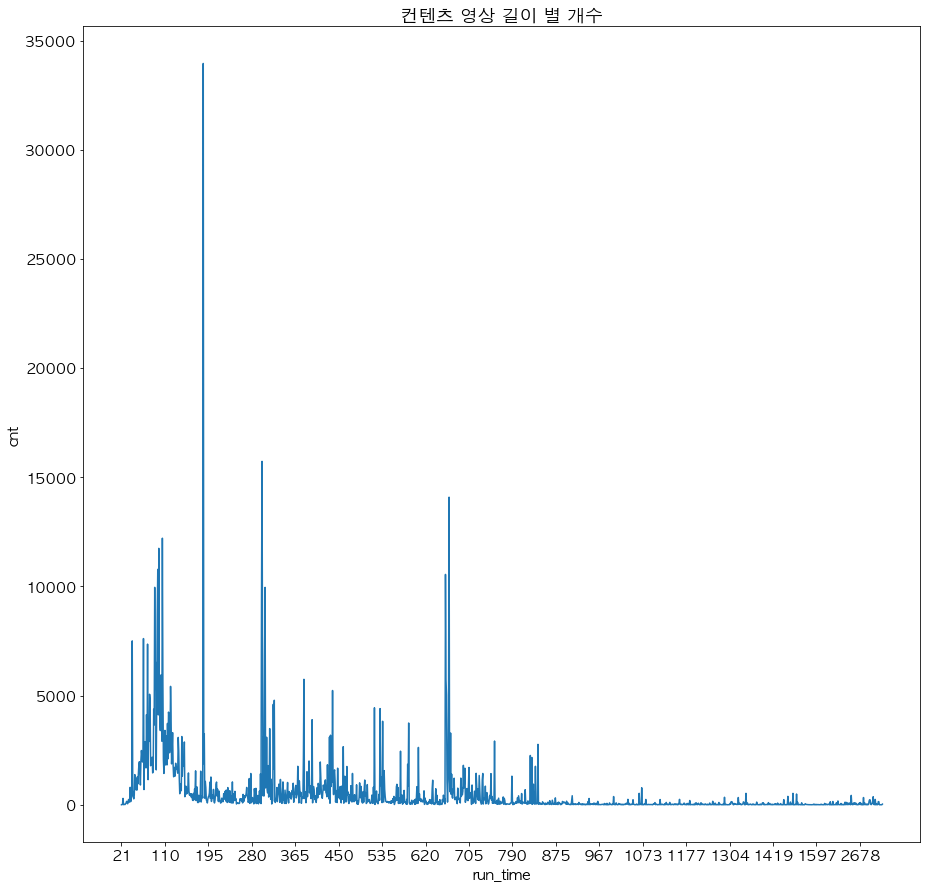

In [30]:
# 전체 컨텐츠 영상 시간별 cnt 비교
plt.figure(figsize=(15,15))
sns.lineplot(x='run_time',y='cnt',data=watch_e_meta_profile_runtimepercent_groupby)
plt.xticks(range(0,len(watch_e_meta_profile_runtimepercent_groupby),85))
plt.title('컨텐츠 영상 길이 별 개수')
plt.show()

In [203]:
# 유저 시청시간과 컨텐츠 전체 영상 길이 퍼센트화 및 컨테츠별 퍼센트 평균
watch_e_meta_profile_runtimepercent_mean = watch_e_meta_profile_runtimepercent.groupby(['album_id']).mean()['runtime_percent'].reset_index().rename(columns={'runtime_percent':'runtime_percent_mean'})
watch_e_meta_profile_runtimepercent_mean['album_id'] = watch_e_meta_profile_runtimepercent_mean['album_id'].astype(str)
watch_e_meta_profile_runtimepercent_mean = watch_e_meta_profile_runtimepercent_mean.sort_values(by='runtime_percent_mean',ascending=False)

In [204]:
# 평균적으로 컨텐츠는 0.6 이상 봄
watch_e_meta_profile_runtimepercent_mean.describe()

,runtime_percent_mean
count,20361.000000
mean,0.602252
std,0.319543
min,0.000000
25%,0.385485
50%,0.648990
75%,0.844093
max,5.766667


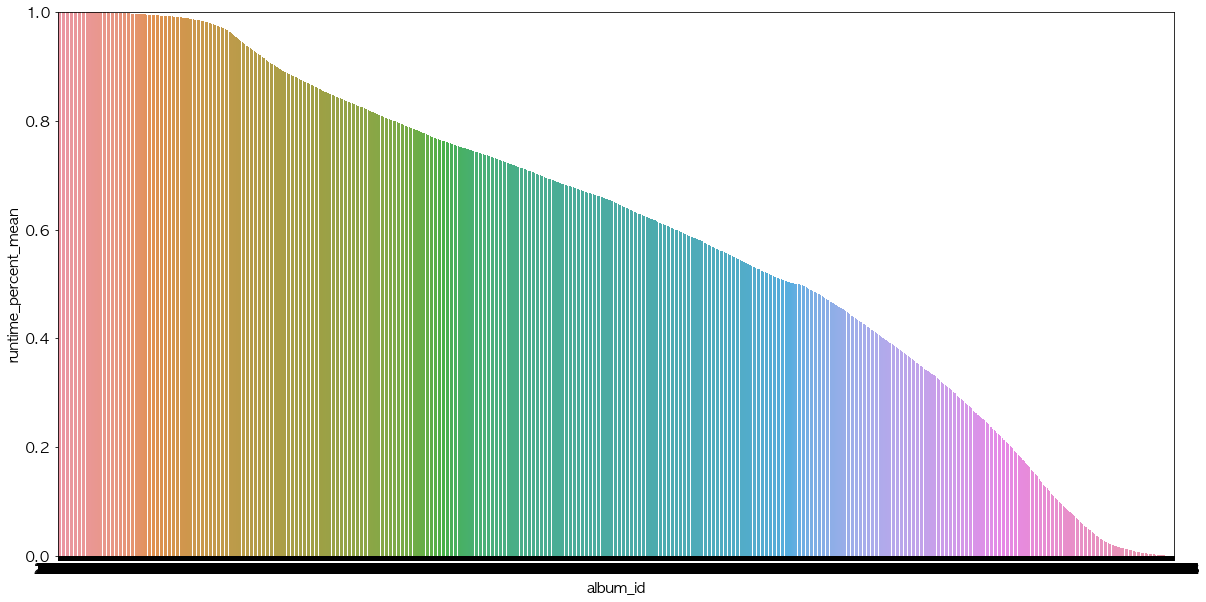

In [205]:
# 앨범 컨텐츠 유저 평균 시청 퍼센트
plt.figure(figsize=(20,10))
sns.barplot(x='album_id',y='runtime_percent_mean',data=watch_e_meta_profile_runtimepercent_mean)
plt.ylim([0,1])
plt.show()

- 영상 길이가 길면 어쩔 수 없게 퍼센트도 떨어질 것이라고 생각됨
- 따라서 영상 길이가 좀 적은 것에 대해서 퍼센트 비교 후 neg 가능 예상

In [264]:
# 전체 컨텐츠 중 200 이상 클릭된 컨텐츠 확인
up200 = watch_e_meta_profile_runtimepercent.album_id.value_counts()
up200_watch_e_meta_profile_runtimepercent = watch_e_meta_profile_runtimepercent[watch_e_meta_profile_runtimepercent['album_id'].isin(list(up200[up200>=1000].index))]
up200_watch_e_meta_profile_runtimepercent_mean = up200_watch_e_meta_profile_runtimepercent.groupby(['album_id']).mean()['runtime_percent'].reset_index().rename(columns={'runtime_percent':'runtime_percent_mean'})
up200_watch_e_meta_profile_runtimepercent_mean['album_id'] = up200_watch_e_meta_profile_runtimepercent_mean['album_id'].astype(str)
up200_watch_e_meta_profile_runtimepercent_mean = up200_watch_e_meta_profile_runtimepercent_mean.sort_values(by='runtime_percent_mean',ascending=False)

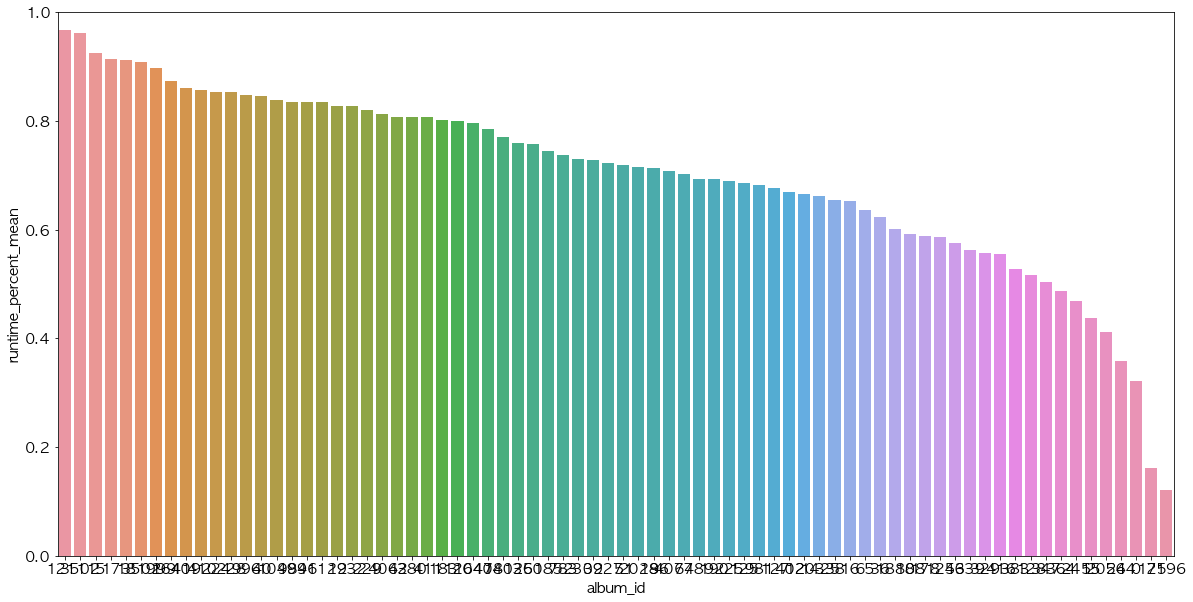

In [265]:
# 200 번 이상 클릭된 컨텐츠 영상
plt.figure(figsize=(20,10))
sns.barplot(x='album_id',y='runtime_percent_mean',data=up200_watch_e_meta_profile_runtimepercent_mean)
plt.ylim([0,1])
plt.show()

- 200 번 클릭했는데도 평균 시청률이 0.3 프로 미만이라면 이는 확실한 neg 판단 됨
- 물론 오류로 많이 클릭했을 가능성도 있지만 이런 사항까지 판단하기 어려울 것으로 생각 됨

In [266]:
up200_album_id = up200_watch_e_meta_profile_runtimepercent_mean[up200_watch_e_meta_profile_runtimepercent_mean['runtime_percent_mean']<0.3].album_id
up200_neg_album_df = history_meta_profile_duplicate_df[history_meta_profile_duplicate_df['album_id'].isin(list(up200_album_id.astype(int)))]
up200_neg_meta_df = up200_neg_album_df.drop_duplicates(subset=['album_id','title'])[['album_id','title','sub_title','genre_large','genre_mid','short_trailer','run_time']]
up200_neg_meta_df

,album_id,title,sub_title,genre_large,genre_mid,short_trailer,run_time
197,175,웨이비 존스의 사물함,[아기상어 올리와 윌리엄(상)],키즈,TV만화,N,719
3827,2196,아기 고릴라와 함께 연주해요,[엄마까투리3],키즈,TV만화,Y,324


## 2. MP 확인

In [72]:
# 컨텐츠 제목 순위 및 top100 그리고 장르 순위 시각화
history_title_large_genre = history_meta_profile_duplicate_df.groupby(['title','genre_large']).count()['profile_id'].reset_index().rename(columns={'profile_id':'cnt'})
history_title_large_genre = history_title_large_genre.sort_values(by='cnt',ascending=False)
history_title_large_genre_top100 = history_title_large_genre.iloc[:100,:]

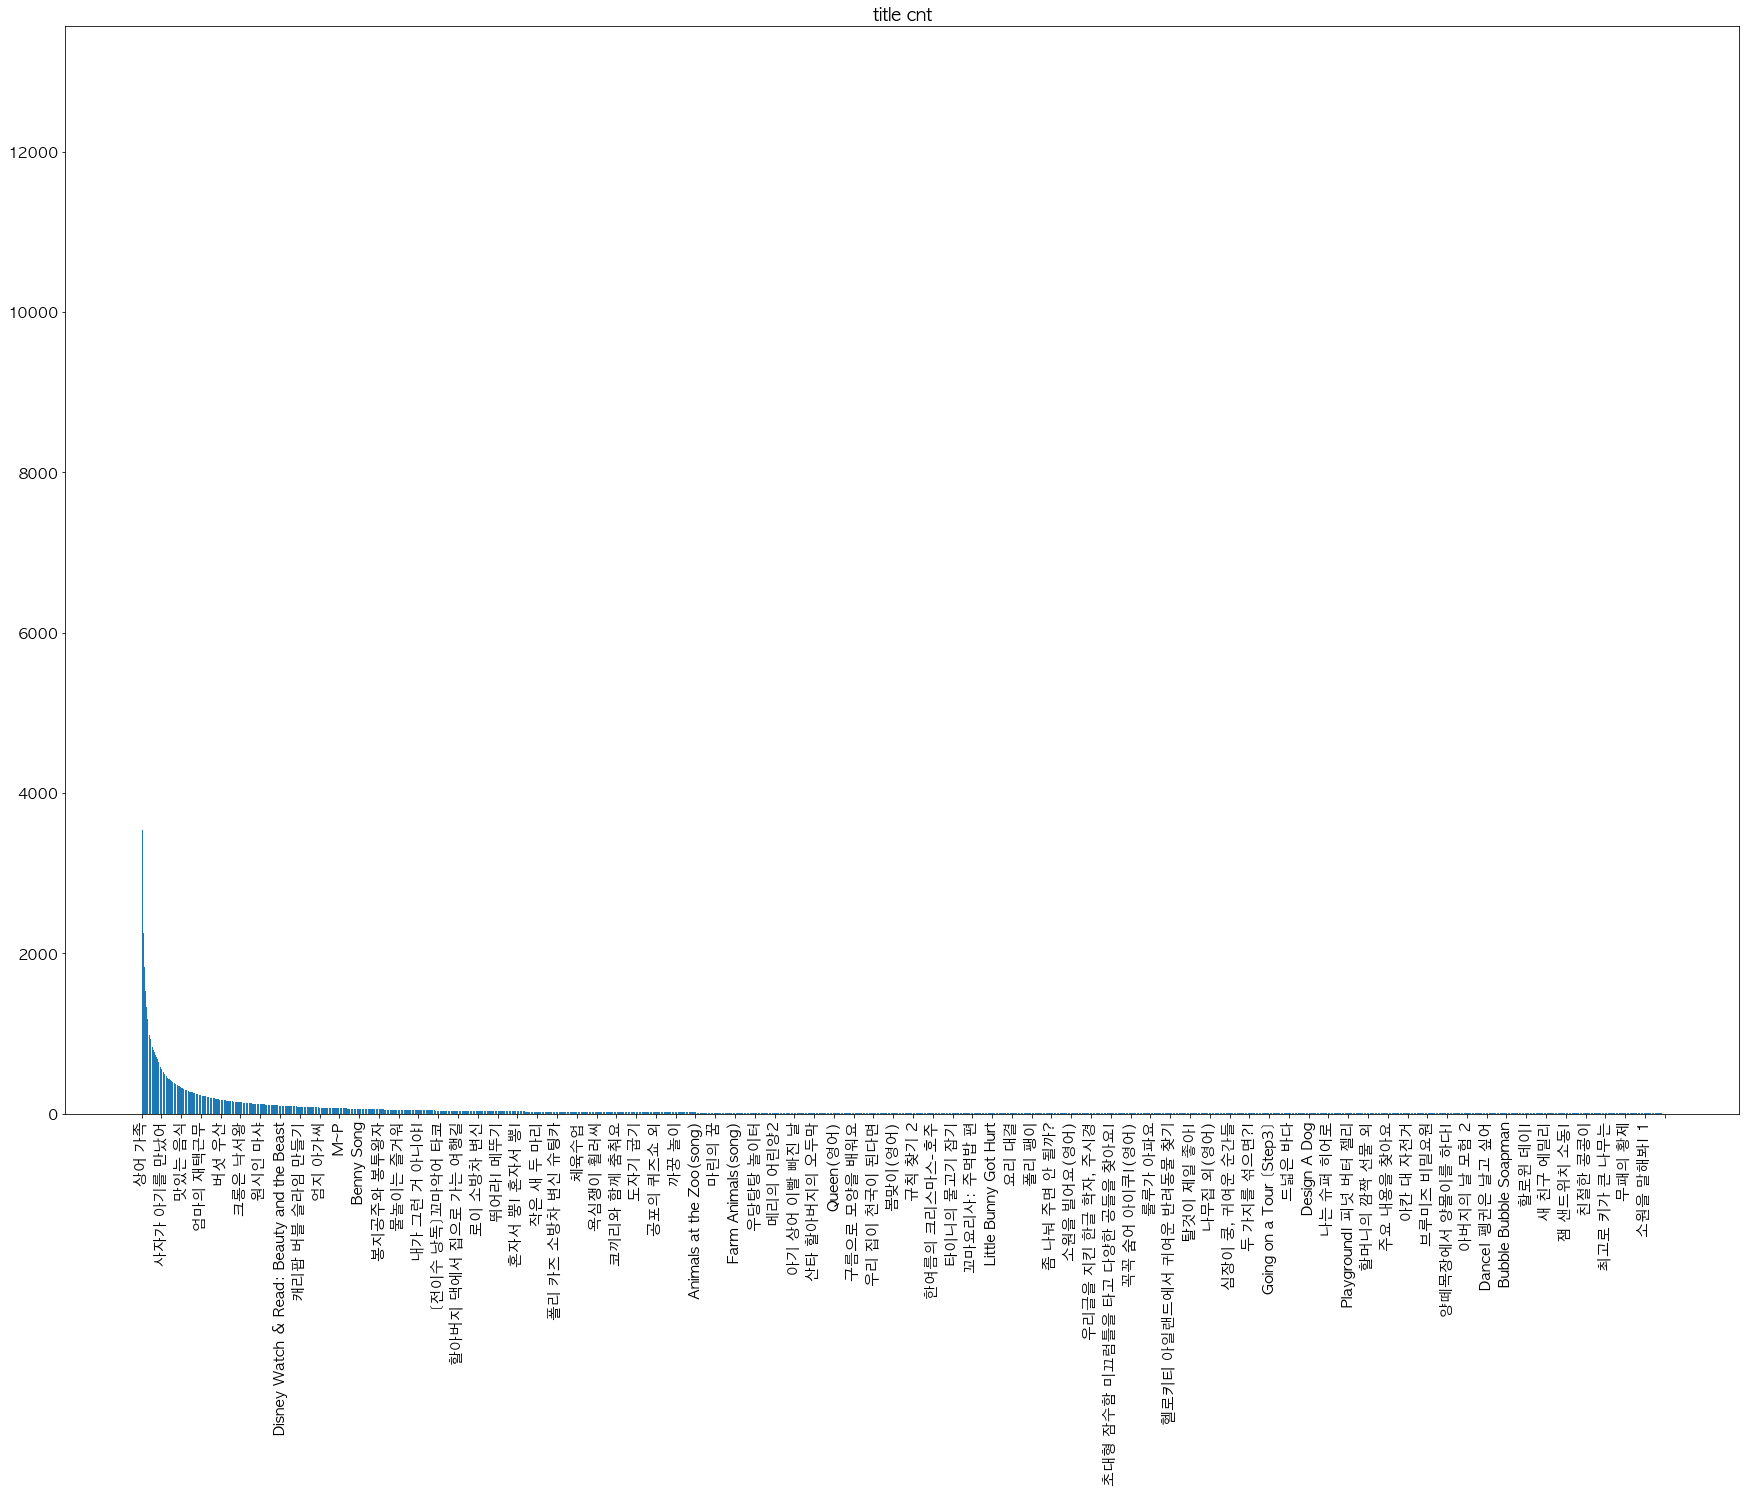

In [81]:
# 전체 컨텐츠 제목 순위
plt.figure(figsize=(30,20))
plt.bar(x='title', height='cnt', data= history_title_large_genre)
plt.title('title cnt')
plt.xticks(range(0,len(history_title_large_genre),250), rotation=90)
plt.show()

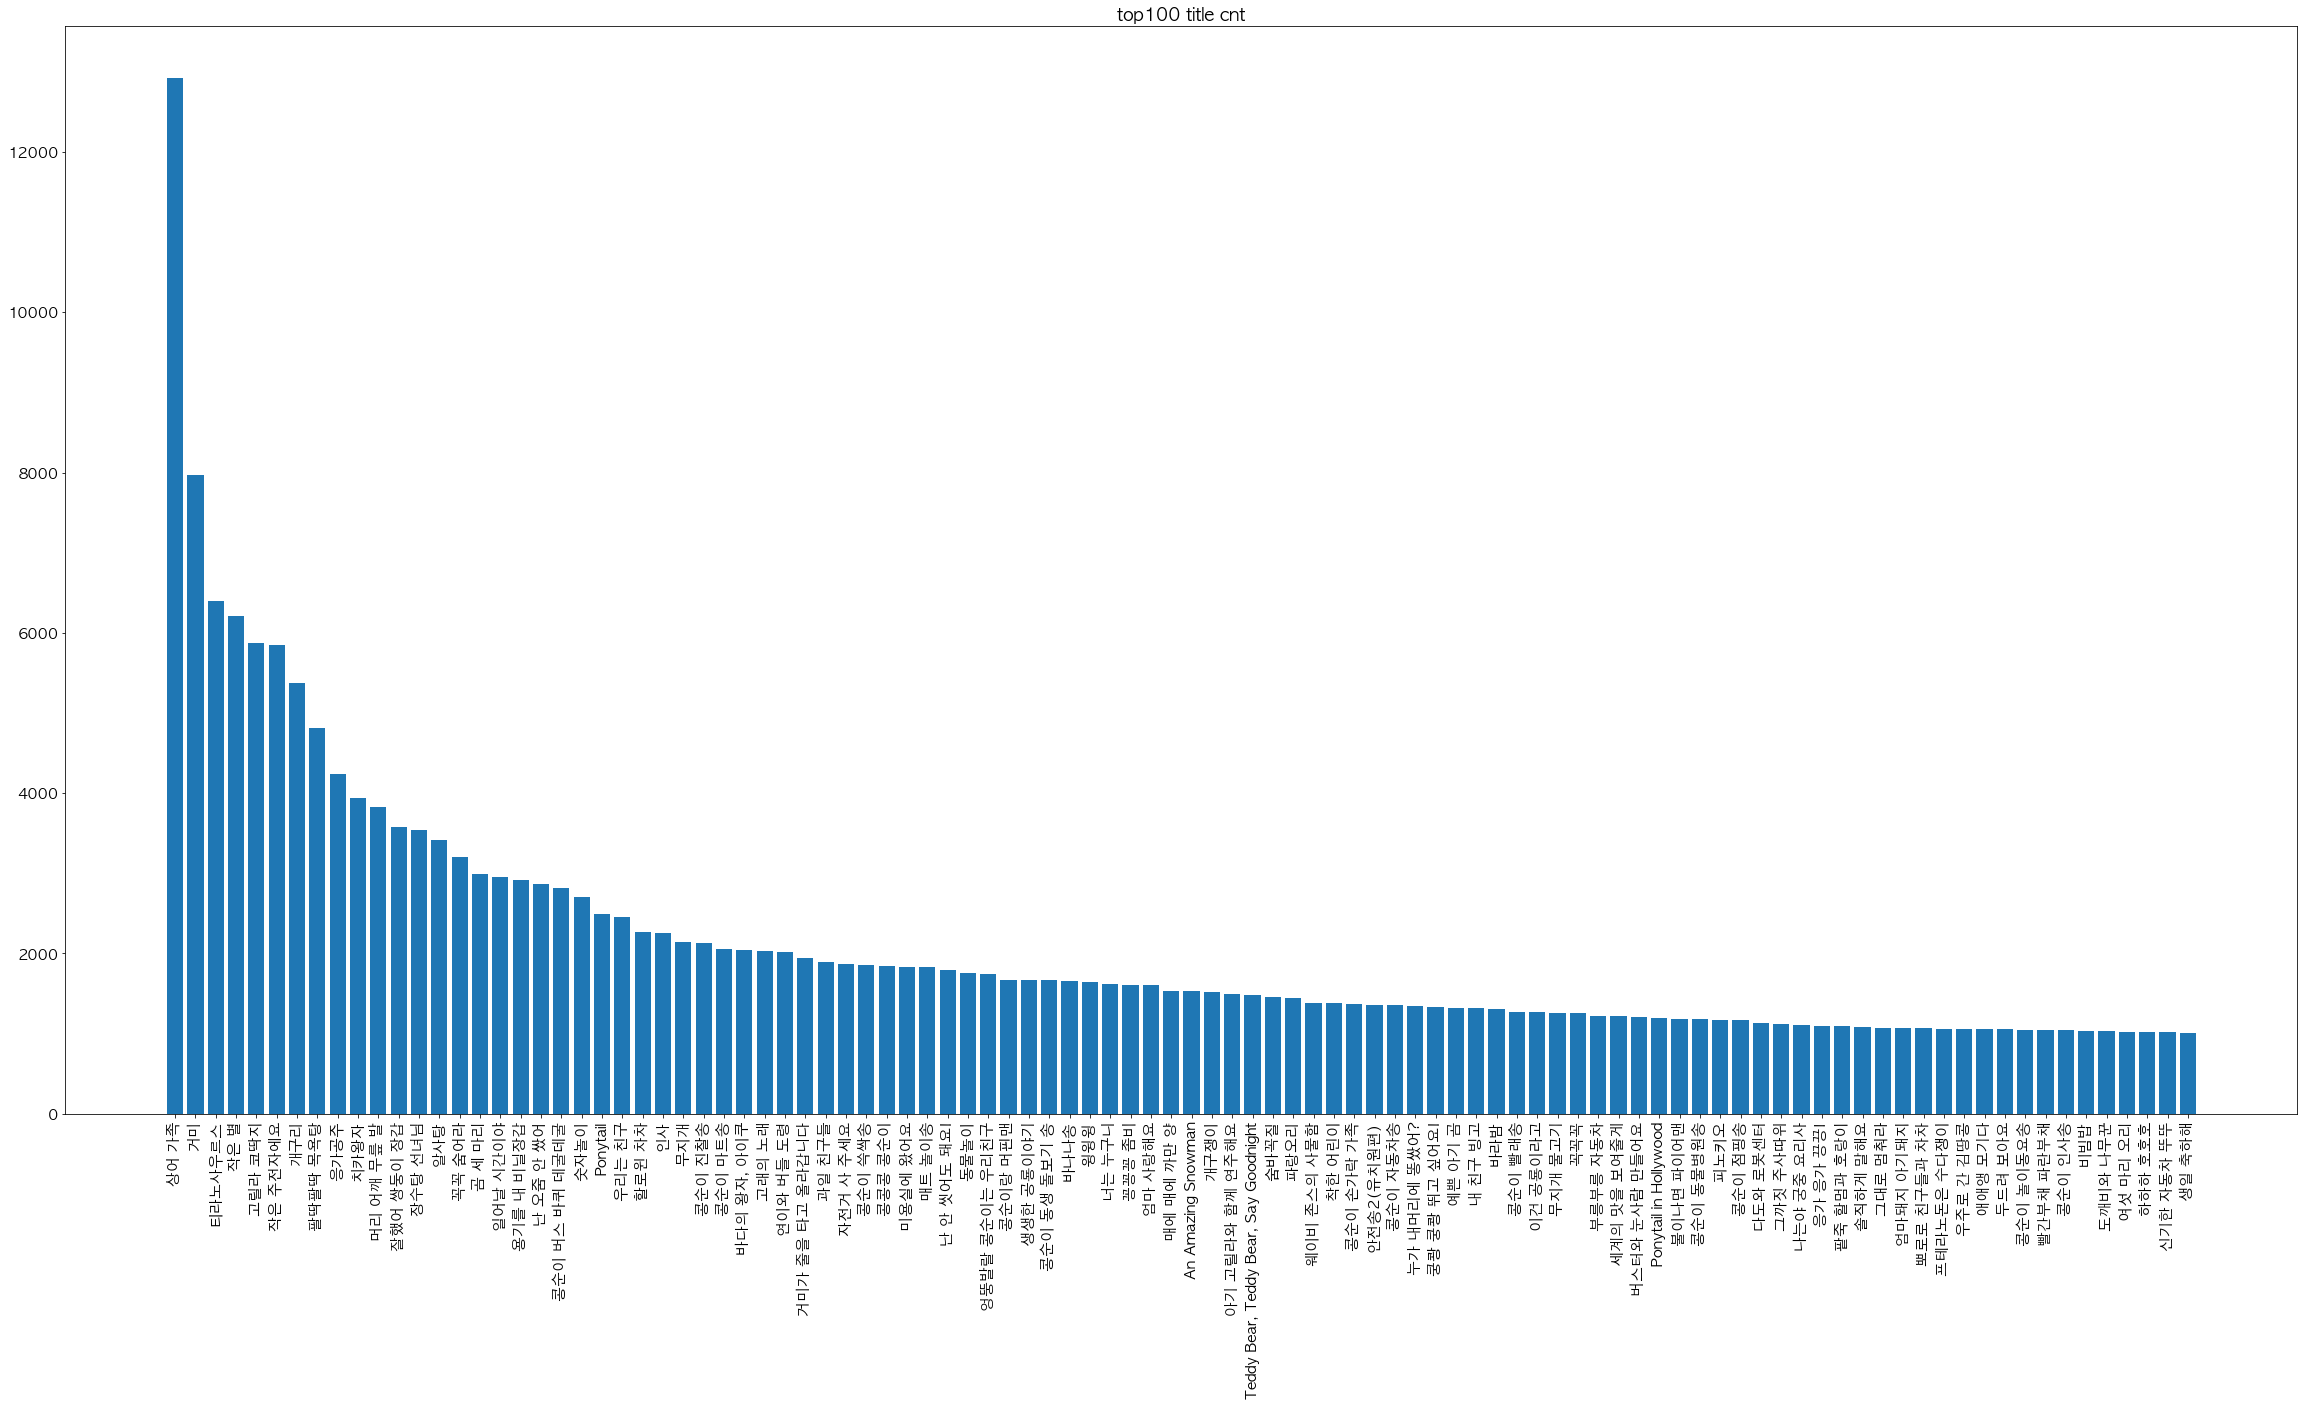

In [199]:
# 컨텐츠 제목 100top
plt.figure(figsize=(40,20))

plt.bar(x='title', height='cnt', data= history_title_large_genre_top100)
plt.title('top100 title cnt')
plt.xticks(rotation=90)
plt.show()

In [164]:
# meta fill na None
all_meta_df['genre_large'] = all_meta_df['genre_large'].fillna('None')
all_meta_df['genre_mid'] = all_meta_df['genre_mid'].fillna('None')
all_meta_df['genre_small'] = all_meta_df['genre_small'].fillna('None')

# history fill na None
history_meta_profile_duplicate_df['genre_large'] = history_meta_profile_duplicate_df['genre_large'].fillna('None')
history_meta_profile_duplicate_df['genre_mid'] = history_meta_profile_duplicate_df['genre_mid'].fillna('None')
history_meta_profile_duplicate_df['genre_small'] = history_meta_profile_duplicate_df['genre_small'].fillna('None')

# meta genre
genre_large_meta = all_meta_df.genre_large.value_counts().reset_index().rename(columns={'index':'genre_large','genre_large':'cnt'})
genre_mid_meta = all_meta_df.genre_mid.value_counts().reset_index().rename(columns={'index':'genre_mid','genre_mid':'cnt'})
genre_small_meta = all_meta_df.genre_small.value_counts().reset_index().rename(columns={'index':'genre_small','genre_small':'cnt'})

# history genre
genre_large_history = history_meta_profile_duplicate_df.groupby(['genre_large']).count()['profile_id'].reset_index().rename(columns={'profile_id':'genre_large','profile_id':'cnt'}).sort_values(by='cnt',ascending=False).reset_index(drop=True)
genre_mid_history = history_meta_profile_duplicate_df.groupby(['genre_mid']).count()['profile_id'].reset_index().rename(columns={'profile_id':'genre_mid','profile_id':'cnt'}).sort_values(by='cnt',ascending=False).reset_index(drop=True)
genre_small_history = history_meta_profile_duplicate_df.groupby(['genre_small']).count()['profile_id'].reset_index().rename(columns={'profile_id':'genre_small','profile_id':'cnt'}).sort_values(by='cnt', ascending=False).reset_index(drop=True)

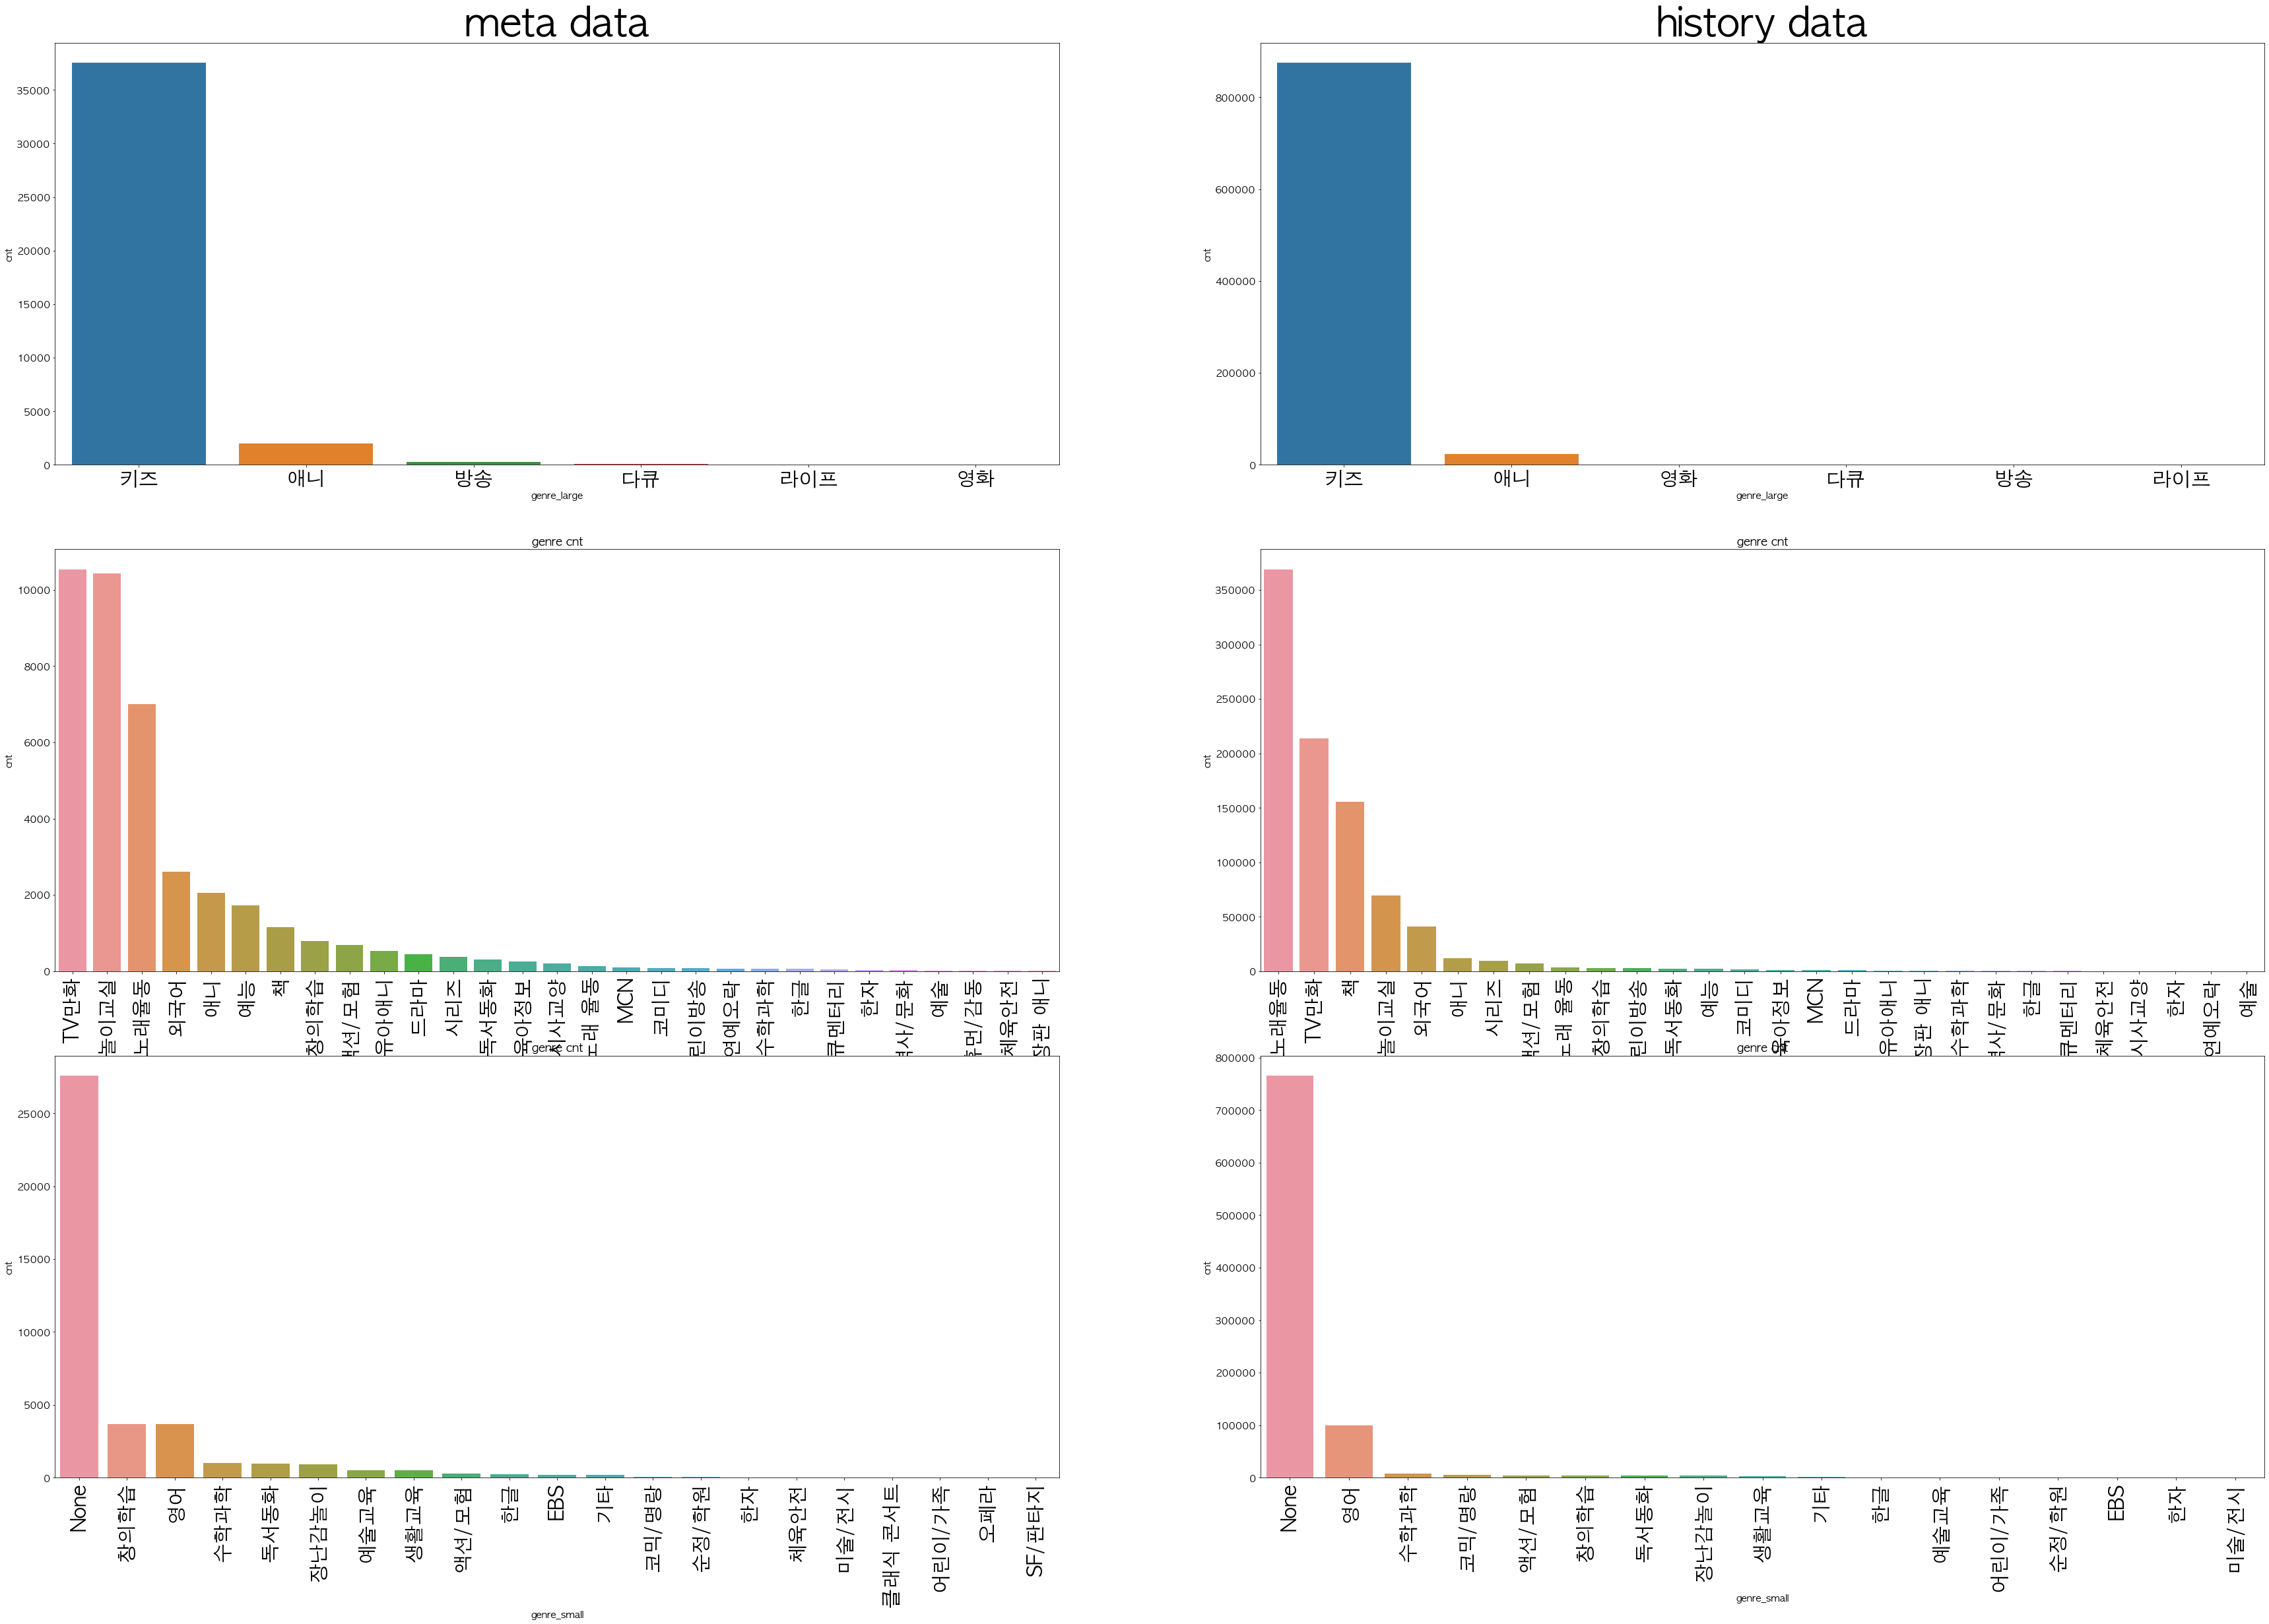

In [143]:
plt.figure(figsize=(60,40))

# 컨텐츠 장르 순위
plt.subplot(321)
sns.barplot(x='genre_large',y='cnt',data=genre_large_meta)
plt.title('genre cnt')
plt.xticks(fontsize=30)
plt.title('meta data', fontsize=60)

plt.subplot(322)
sns.barplot(x='genre_large',y='cnt',data=genre_large_history)
plt.title('genre cnt')
plt.xticks(fontsize=30)
plt.title('history data', fontsize=60)

plt.subplot(323)
sns.barplot(x='genre_mid',y='cnt',data=genre_mid_meta)
plt.title('genre cnt')
plt.xticks(fontsize=30, rotation=90)

plt.subplot(324)
sns.barplot(x='genre_mid',y='cnt',data=genre_mid_history)
plt.title('genre cnt')
plt.xticks(fontsize=30, rotation=90)

plt.subplot(325)
sns.barplot(x='genre_small',y='cnt',data=genre_small_meta)
plt.title('genre cnt')
plt.xticks(fontsize=30, rotation=90)

plt.subplot(326)
sns.barplot(x='genre_small',y='cnt',data=genre_small_history)
plt.title('genre cnt')
plt.xticks(fontsize=30, rotation=90)
plt.show()
#

## 비교 결론
### large 장르
- large genre 똑깥음

### mid 장르
- 컨텐츠 수: TV만화, 놀이교실, 노래율동, 외국어, 애니
- 컨텐츠 시청 수: 노래율동, TV만화, 책, 놀이교실, 외국어
- 결론적으로 노래율동, 놀이교실, TV만화, 외국어는 상위권이 동일하나
- 책 장르가 압도적으로 높아진 것을 확인 가능

### small 장르
- 대부분 None 값으로 무언가 비교가 힘듬
- 다만, 창의학습이 아얘 순위에서 사라졌음을 확인

### 총 결론
- 책 도서 추천이 중요하게 작용할 것 같다
- 왜냐하면 컨텐츠 수가 적음에도 불구하고 실제로는 많이 시청이 되는 것 확인

In [188]:
# 컨텐츠 장르 순위 증감률 시각화
genre_df_list = [genre_large_meta, genre_mid_meta, genre_small_meta, genre_large_history, genre_mid_history, genre_small_history]
for df in genre_df_list:
    df['rank'] = df.index
    
mid_rank_df = pd.merge(genre_mid_history, genre_mid_meta[['genre_mid','rank']], how='left', on='genre_mid')
mid_rank_df['rank'] = mid_rank_df['rank_y']-mid_rank_df['rank_x']
mid_rank_df = mid_rank_df.drop(columns=['rank_x','rank_y'])

small_rank_df = pd.merge(genre_small_history, genre_small_meta[['genre_small','rank']], how='left', on='genre_small')
small_rank_df['rank'] = small_rank_df['rank_y']-small_rank_df['rank_x']
small_rank_df = small_rank_df.drop(columns=['rank_x','rank_y'])

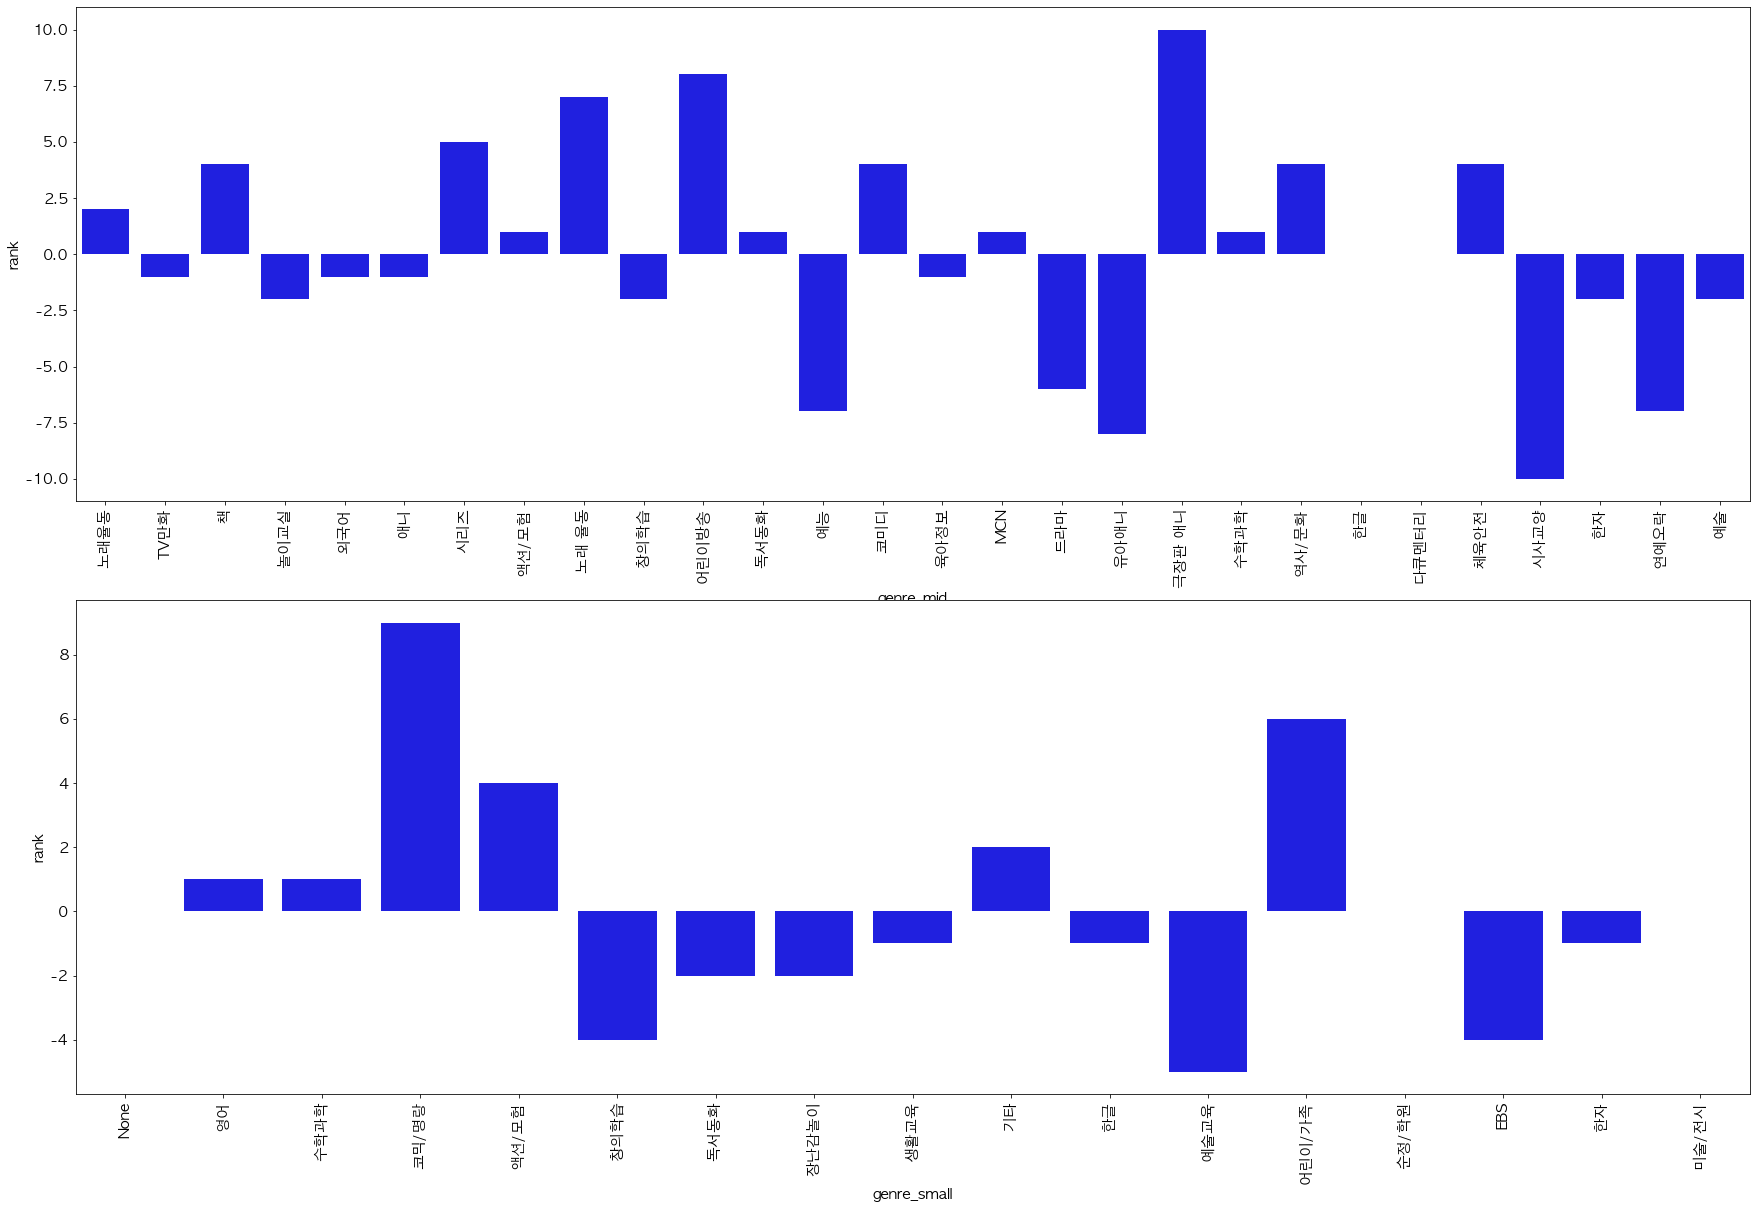

In [198]:
plt.figure(figsize=(30,20))
plt.subplot(211)
sns.barplot(x='genre_mid', y= 'rank', data=mid_rank_df, color='blue')
plt.xticks(rotation=90)

plt.subplot(212)
sns.barplot(x='genre_small', y= 'rank', data=small_rank_df, color='blue')
plt.xticks(rotation=90)
plt.show()

- 증가 top3: 극장판 애니, 어린이 방송, 노래 율동 | 하락 top3: 시사교양, 유아애니, 연예 오락
- 증가 top3: 코믹/명량, 어린이/가족, 액션/모험  | 하락 top3: 예술교육, EBS, 창의학습   
상위 증가 컨텐츠 장르들은 적은 컨텐츠 수임에도 많은 시청이 이루어짐   
이는 MP 해당하는 컨텐츠가 많은 것으로 판단 됨   
반면, 아얘 시청이 안된 장르 컨텐츠 이거나 하락폭이 심한 컨텐츠에 경우 neg sampling 봐도 좋지 않을까 생각 됨

다른 생각
- 기간별로도 꾸준히 장르 순위가 유지된다면 그 장르는 정말 MP 아이템이 많은 것으로 볼 수 있음
- 확인이 필요

## 3. buy data pay 이용한 neg sampling 구하기

In [ ]:
['profile_id'].reset_index().rename(columns={'profile_id':'cnt'})

In [85]:
history_meta_profile_duplicate_df

,genre_mid,cnt
0,MCN,845
1,TV만화,213894
2,극장판 애니,728
3,노래 율동,3295
4,노래율동,369013
5,놀이교실,69510
6,다큐멘터리,366
7,독서동화,2510
8,드라마,788
9,수학과학,645
